<font face='serif' size=4>
<span style="line-height: 1.25;">

# HW8 for Statistics with Meteorological Application
---
Student: 林之然 (B11209005, 大氣二), 蔡知諺（B11209014, 大氣二）

#### Import necessary packages

In [234]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from sklearn.model_selection import train_test_split
from tqdm import tqdm
import time
import logging

#### Check cuda is avaliable

In [235]:
# Check mps is available
try: device = torch.device("mps")
except: device = torch.device("cpu")
print(f"Using device: {device}")

Using device: mps


#### Training data visualization

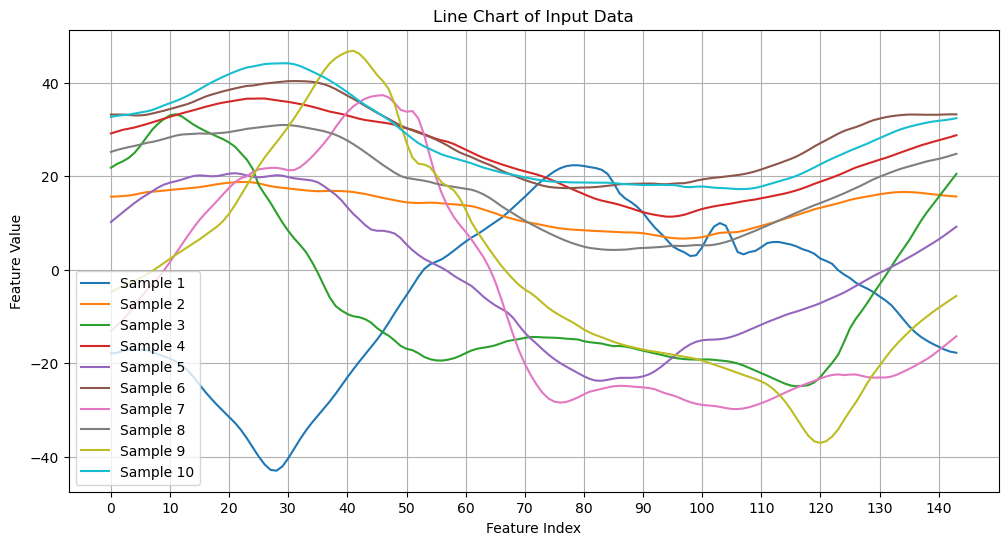

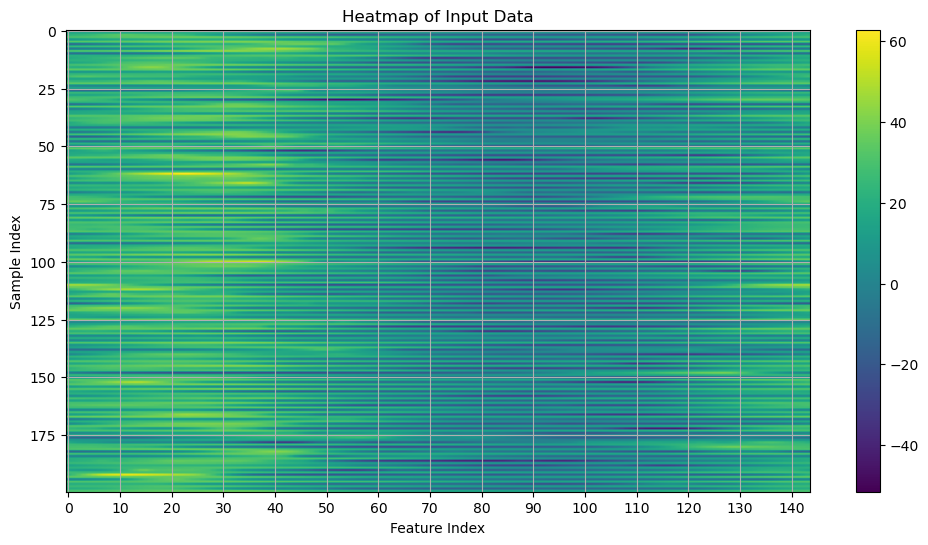

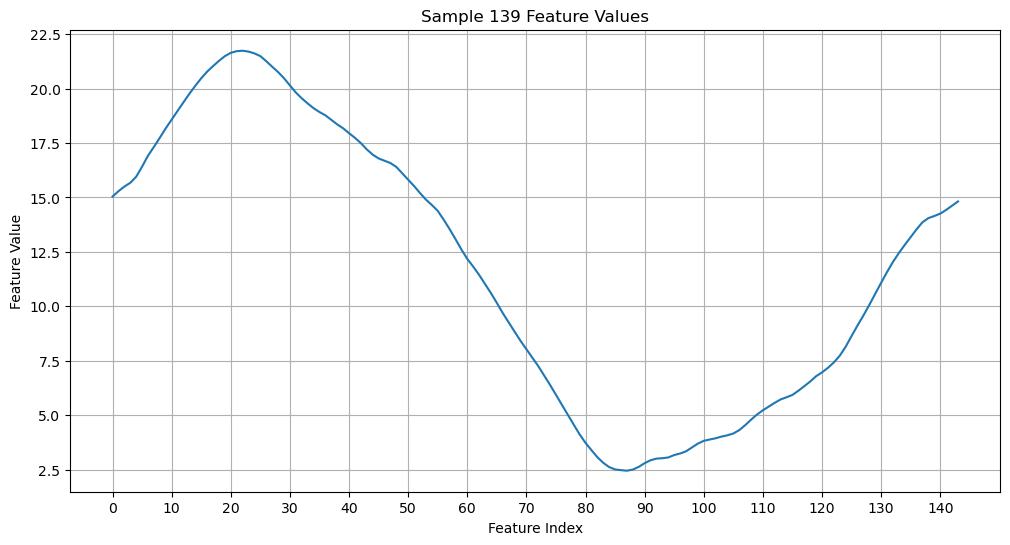

In [236]:
# Read the input data
dfx = pd.read_csv('./hw10_u_x.csv', skiprows=0)

# Drop the first column
dfx = dfx.drop(columns=['Unnamed: 0'])

# Visualize the input data
def plot_line_chart(data):
    plt.figure(figsize=(12, 6))
    for i in range(min(len(data), 10)):
        plt.plot(data.iloc[i], label=f'Sample {i+1}')
    plt.xlabel('Feature Index')
    plt.ylabel('Feature Value')
    plt.title('Line Chart of Input Data')
    plt.xticks(np.arange(0, data.shape[1], 10))
    plt.legend()
    plt.grid()
    plt.show()

def plot_heatmap(data):
    plt.figure(figsize=(12, 6))
    plt.imshow(data, aspect='auto', cmap='viridis')
    plt.colorbar()
    plt.xlabel('Feature Index')
    plt.ylabel('Sample Index')
    plt.title('Heatmap of Input Data')
    plt.xticks(np.arange(0, data.shape[1], 10))
    plt.grid()
    plt.show()

def plot_sample(data, sample_index):
    plt.figure(figsize=(12, 6))
    plt.plot(data.iloc[sample_index])
    plt.xlabel('Feature Index')
    plt.ylabel('Feature Value')
    plt.title(f'Sample {sample_index} Feature Values')
    plt.xticks(np.arange(0, data.shape[1], 10))
    plt.grid()
    plt.show()

# Plot the line chart, heatmap, and a random sample
plot_line_chart(dfx)
plot_heatmap(dfx)
plot_sample(dfx, sample_index=np.random.randint(len(dfx)))

#### Define functions

In [237]:
def get_n_params(model):
    np=0
    for p in list(model.parameters()):
        np += p.nelement()

    return np

class LogisticRegression(nn.Module):
    """
    Neural Network model with multiple hidden layers.

    Args:
        input_size (int): The number of input features.
        hidden_size (int): The number of neurons in each hidden layer.
        output_size (int): The number of output classes.

    Attributes:
        fc1 (nn.Linear): The first fully connected layer.
        fc2 (nn.Linear): The second fully connected layer.
        fc3 (nn.Linear): The output layer.

    Methods:
        forward(x): Performs forward pass through the model.

    """

    def __init__(self, input_size, hidden_size, output_size):
        super(LogisticRegression, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.fc2 = nn.Linear(hidden_size, 32)
        self.fc3 = nn.Linear(32, output_size)

    def forward(self, x):
        """
        Performs forward pass through the model.

        Args:
            x (torch.Tensor): The input tensor.

        Returns:
            torch.Tensor: The output tensor.

        """
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = torch.sigmoid(self.fc3(x))
        return x

def train(model, x, y, optimizer):
    """
    Trains the given model using the provided input data and optimizer.

    Args:
        model (torch.nn.Module): The model to be trained.
        x (torch.Tensor): The input data.
        y (torch.Tensor): The target labels.
        optimizer (torch.optim.Optimizer): The optimizer used for training.

    Returns:
        tuple: A tuple containing the loss and the output of the model.
    """
    x, y = x.to(device), y.to(device)
    model.zero_grad()    # Set gradients of all model parameters to zero
    output = model(x)
    output = torch.squeeze(output)
    loss = F.binary_cross_entropy(output, y)
    loss.backward()
    optimizer.step()

    return loss, output

def test(model, x, y):
    x, y = x.to(device), y.to(device)
    model.eval()    # switch model to evaluate mode
    output = model(x)
    output = torch.squeeze(output)
    loss = F.binary_cross_entropy(output, y)

    return loss, output

def calculate_accuracy(y_true, y_pred):
    y_true, y_pred = y_true.to(device), y_pred.to(device)
    predicted = y_pred.ge(.5).view(-1)
    err_num = (y_true != predicted).sum()
    accuracy = (y_true == predicted).sum().float()/len(y_true)

    return err_num, accuracy

#### Load data and transform into tensor

Data: zonal wind at 10hPa, 60 deg N

In [238]:
path = './'
dfx = pd.read_csv(path+'hw10_u_x.csv', skiprows=0, usecols=np.arange(1,145)) # cases(200) x lon(144)
dfy = pd.read_csv(path+'hw10_u_y.csv', skiprows=0, usecols=[1]) # 200 x 1
x_train, x_test, y_train, y_test = train_test_split(dfx, dfy, test_size=0.3, random_state=42)  # 70% training and 30% test

# convert all fields to Tensors
x_train = torch.from_numpy(x_train.to_numpy()).float()
y_train = torch.squeeze(torch.from_numpy(y_train.to_numpy()).float())
x_test = torch.from_numpy(x_test.to_numpy()).float()
y_test = torch.squeeze(torch.from_numpy(y_test.to_numpy()).float())
print('x_train:', x_train.shape, 'y_train:', y_train.shape)
print('x_test:', x_test.shape,'y_test:',  y_test.shape)

lon = np.linspace(0,358.75,144)

x_train: torch.Size([140, 144]) y_train: torch.Size([140])
x_test: torch.Size([60, 144]) y_test: torch.Size([60])


#### Hyperparameters and configurations

In [239]:
# hyperparameters
input_size  = 144  # number of features
hidden_size = 64  # number of hidden units
output_size = 1  # binary classification
EPOCHS      = 10  # number of epochs
lr          = 1e-2  # learning rate
wd          = 1e-5    # weight decay

# model
model_logreg = LogisticRegression(input_size, hidden_size, output_size)
model_logreg.to(device)

# optimizer: stochastic gradient descent
optimizer = optim.SGD(model_logreg.parameters(), lr=lr, weight_decay=wd)  # weight_decay is L2 regularization
Accuracy = np.zeros((EPOCHS, 2))  # epochs, train/test
Loss = np.zeros((EPOCHS, 2))  # epochs, train/test

#### Training loop

In [240]:
# Use tqdm to show the progress bar
start_time = time.time()
logging.basicConfig(filename='hw8_training.log', level=logging.INFO)
for epoch in tqdm(range(EPOCHS), desc='Training progress'):
    x_train = x_train.view(-1, 144)
    x_train, y_train = x_train.to(device), y_train.to(device)
    train_loss, train_pred = train(model_logreg, x_train, y_train, optimizer)
    train_errnum, train_acc = calculate_accuracy(y_train, train_pred)
    test_loss, test_pred = test(model_logreg, x_test, y_test)
    test_errnum, test_acc = calculate_accuracy(y_test, test_pred)
    
    message = 'Epoch {}\n'.format(epoch+1)
    message += '     Train set - loss: {}\n'.format(train_loss)
    message += '     Train set - accuracy: {}\n'.format(train_acc)
    message += '     Test set - loss: {}\n'.format(test_loss)
    message += '     Test set - accuracy: {}\n'.format(test_acc)
    message += '     Number of test errors: {}\n'.format(test_errnum)
    
    # Write the message to th log file
    logging.info(message)
    
    Accuracy[epoch,0], Accuracy[epoch,1] = train_acc, test_acc
    Loss[epoch,0], Loss[epoch,1] = train_loss, test_loss

# Calculate total training time
train_time = time.time() - start_time
print(f'Training time for {EPOCHS} epochs: {train_time:.2f} seconds')

Training progress: 100%|██████████| 10/10 [00:00<00:00, 102.10it/s]

Training time for 10 epochs: 0.10 seconds


#### Plot the results

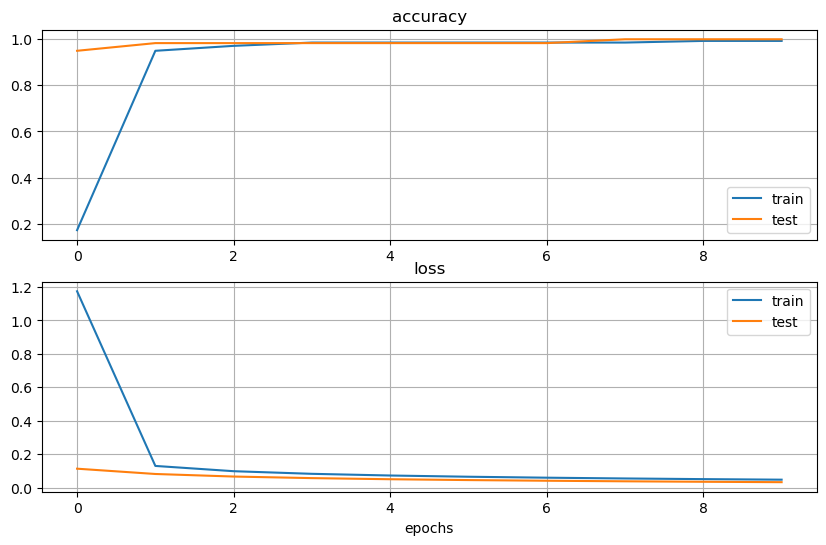

In [241]:
# plot accuracy
plt.close('all')
fig = plt.figure(figsize=(10, 6))
ax0 = fig.add_subplot(211)
ax1 = fig.add_subplot(212)
ax0.plot(np.arange(0,EPOCHS), Accuracy[:,0], label='train')
ax0.plot(np.arange(0,EPOCHS), Accuracy[:,1], label='test')
#ax0.set_xscale('log')
ax0.legend()
ax0.title.set_text('accuracy')
ax0.grid()

# plot loss
ax1.plot(np.arange(0,EPOCHS), Loss[:,0], label='train')
ax1.plot(np.arange(0,EPOCHS), Loss[:,1], label='test')
#ax1.set_xscale('log')
ax1.legend()
ax1.title.set_text('loss')
ax1.set_xlabel('epochs')
ax1.grid()

plt.show()

#### cf. Comparasion on CPU and MPS

In [242]:
# Function to measure time
def measure_time(func, *args, **kwargs):
    start = time.time()
    result = func(*args, **kwargs)
    end = time.time()
    return result, end - start

# Measure CPU time
device = torch.device("cpu")
model_logreg.to(device)
train_time_cpu = []
test_time_cpu = []
for epoch in tqdm(range(EPOCHS), desc='Training on CPU'):
    x_train, y_train = x_train.to(device), y_train.to(device)
    x_test, y_test = x_test.to(device), y_test.to(device)
    _, train_time = measure_time(train, model_logreg, x_train, y_train, optimizer)
    _, test_time = measure_time(test, model_logreg, x_test, y_test)
    train_time_cpu.append(train_time)
    test_time_cpu.append(test_time)

print(f"Average train time on CPU: {np.mean(train_time_cpu):.4f} seconds")
print(f"Average test time on CPU: {np.mean(test_time_cpu):.4f} seconds")

# Measure MPS time
device = torch.device("mps")
model_logreg.to(device)
train_time_mps = []
test_time_mps = []
for epoch in tqdm(range(EPOCHS), desc='Training on MPS'):
    x_train, y_train = x_train.to(device), y_train.to(device)
    x_test, y_test = x_test.to(device), y_test.to(device)
    _, train_time = measure_time(train, model_logreg, x_train, y_train, optimizer)
    _, test_time = measure_time(test, model_logreg, x_test, y_test)
    train_time_mps.append(train_time)
    test_time_mps.append(test_time)

print(f"Average train time on MPS: {np.mean(train_time_mps):.4f} seconds")
print(f"Average test time on MPS: {np.mean(test_time_mps):.4f} seconds")


Training on CPU: 100%|██████████| 10/10 [00:00<00:00, 2266.95it/s]


Average train time on CPU: 0.0002 seconds
Average test time on CPU: 0.0001 seconds


Training on MPS: 100%|██████████| 10/10 [00:00<00:00, 560.82it/s]

Average train time on MPS: 0.0013 seconds
Average test time on MPS: 0.0003 seconds
